In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = "/content/drive/MyDrive/Colab Notebooks/comp4332/Project3/data"
# !rm -f data
# !ln -s "/content/drive/MyDrive/Colab Notebooks/comp4332/Project3/data" data

In [ ]:
from collections import Counter
from itertools import combinations
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tensorflow.random.set_seed(0)

# Root Mean Squared Error (RMSE)
In this tutorial, RMSE is used to evaluate the performance of a model. A model that reports lower RMSE indicates that it is a better model and vice versa.

In [ ]:
def rmse(pred, actual):
    '''
    params:
        pred <np.array>: an array containing all predicted ratings
        actual <np.array>: an array containing all ground truth ratings

    return:
        a scalar whose value is the rmse
    '''
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

# Wide and Deep Learning (WDL) Model Implementation


In [ ]:
def build_wdl_model(len_continuous, deep_vocab_lens, len_wide, embed_size,deep_hidden_units:list = [256,128,64], dropout_rate = 0.15):
    '''
    params:
        len_continuous: number of continuous features
        deep_vocab_lens: an array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
        len_wide: number of wide features
        embed_size: dimension of the embedding vectors of deep categorical features

    return:
        a keras Model object for the constructed wdl model
    '''
    # A list containing all input layers
    input_list = []

    # Input layer for continuous features
    continuous_input = Input(shape=(len_continuous,), dtype='float32', name='continuous_input')
    input_list.append(continuous_input)

    # Get embeddings for all deep categorical features
    emb_list = []
    for vocab_size in deep_vocab_lens:
        _input = Input(shape=(1,), dtype='int32')
        input_list.append(_input)
        _emb = Embedding(output_dim=embed_size, input_dim=vocab_size, input_length=1)(_input)
        _emb = Reshape((embed_size,))(_emb)
        emb_list.append(_emb)

    # Create input layer for deep component by concatenating the embeddings and continuous features' input layer
    deep_input = Concatenate()(emb_list + [continuous_input])

    for hidden_unit in deep_hidden_units:
      input = Dense(hidden_unit, activation='relu')(deep_input)
      input = Dropout(dropout_rate)(input)

    # Create input layer for wide component
    wide_input = Input(shape=(len_wide,), dtype='float32')
    input_list.append(wide_input)

    # Concatenate the outputs of deep and wide components and feed the concatenated vector into the finall fully connected layer
    fc_input = Concatenate()([input, wide_input])
    model_output = Dense(1)(fc_input)

    model = Model(inputs=input_list, outputs=model_output)
    return model

# Data Preprocessing
Below are codes to perform data preprocessing

In [ ]:
review_df = pd.read_csv('data/review.csv')
val_df = pd.read_csv("data/validation.csv")
pred_df = pd.read_csv('data/prediction.csv')
print("Size of training set:", [len(review_df)])
review_ratings = review_df['Star'].values
print("Size of validation set:", [len(val_df)])
val_ratings = val_df['Star'].values
print("Size of prediction set:", [len(pred_df)])

Size of training set: [52697]
Size of validation set: [6596]
Size of prediction set: [6597]


In [ ]:
import json

with open('data/product.json') as f:
    products = json.load(f)

In [ ]:
#Extract num value from rank ('rank': '88,963 Paid in Kindle Store (' -> 'rank': 88,963)
for product in products:
    rank_value = product['rank']
    if isinstance(rank_value, str):
        # Extracting the numerical part of the rank string
        rank_num = int(rank_value.split()[0].replace(',', ''))
        product['rank'] = rank_num

### Retrieving Continuous Features

In [ ]:
def get_continuous_features(df, continuous_columns):
    '''
    params:
        df: input dataframe
        continuous_columns: column names of continuous features

    return:
        a numpy array where each row contains the values of continuous features in the corresponding row of the input dataframe
    '''
    continuous_features = df[continuous_columns].values
    return continuous_features

In [ ]:
for product in products:
    rank_value = product.get('rank')
    if isinstance(rank_value, str):
        # Extracting the numerical part of the rank string and converting to integer
        rank_num = ''.join(filter(str.isdigit, rank_value))
        if rank_num:
            product['rank'] = int(rank_num)

    if not isinstance(product['rank'], int):
        print("Non-numeric value found in 'rank':", product['rank'])
        product['rank'] = 0

Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []
Non-numeric value found in 'rank': []


### Loading content feautures tables of users and items

In [ ]:
for product in products:
    details = product.get('details', {})

    #Extract num value from details.File Size ('File Size:': '2199 KB' -> 'file_size': 2199)
    file_size_str = details.pop('File Size:', None)
    if file_size_str:
        # Extracting the numerical part of 'File Size'
        file_size_num = int(''.join(filter(str.isdigit, file_size_str)))
        # Adding 'File Size' as a top-level key in the product dictionary
        product['file_size'] = file_size_num

    #Extract num value from details. ('Print Length:': '314 pages' -> 'print_length': 314)
    print_len_str = details.pop('Print Length:', None)
    if print_len_str:
        # Extracting the numerical part of 'Print Length:'
        file_size_num = int(''.join(filter(str.isdigit, print_len_str)))
        # Adding 'Print Length:' as a top-level key in the product dictionary
        product['print_length'] = file_size_num

    #Extract num value from details. ('Publisher:':'Del Rey (September 30, 2003)' -> 'publisher':'Del Rey')
    publisher_str = details.get('Publisher:', '')
    if publisher_str:
        # Remove the date part, if present
        publisher_clean = publisher_str.split('(')[0].strip()
        product['publisher'] = publisher_clean

    product['word_wise'] = details.get('Word Wise:', '')
    product['lending'] = details.get('Lending:', '')
    product['language'] = details.get('Language:', '')

#delete empty columns
for product in products:
  del product['tech1']
  del product['tech2']
  del product['description']
  del product['fit']
  del product['feature']
  del product['similar_item']
  del product['date']
  del product['imageURL']
  del product['imageURLHighRes']
  del product['details']

In [ ]:
# # Convert the products data into a DataFrame
# products_df = pd.DataFrame(products)
# products_df = products_df.rename(index=str, columns={t: 'product_' + t for t in products_df.columns if t != 'ProductID'})
# products_df

### Categorical Features Cross Product Transformation

In [ ]:
def get_top_k_p_combinations(df, comb_p, topk, output_freq=False):
    '''
    params:
        df: input dataframe
        comb_p: number of elements in each combination (e.g., there are two elements in the combination {fried chicken, chicken and waffle}, and three elements in the combination {fried chicken, chicken and waffle, chicken fried rice})
        topk: number of most frequent combinations to retrieve
        output_freq: whether to return the frequencies of retrieved combinations

    return:
        1. output_freq = True: a list X where each element is a tuple containing a combination tuple and corresponding frequency, and the elements are stored in the descending order of their frequencies
        2. output_freq = False: a list X where each element is a tuple containing a combination tuple, and the elements are stored in the descending order of their frequencies
    '''
    def get_category_combinations(categories_str, comb_p=2):
        categories = categories_str
        return list(combinations(categories, comb_p))
    all_categories_p_combos = df["product_category"].apply(lambda x: get_category_combinations(x, comb_p)).values.tolist()
    all_categories_p_combos = [tuple(t) for item in all_categories_p_combos for t in item]
    tmp = dict(Counter(all_categories_p_combos))
    sorted_categories_combinations = list(sorted(tmp.items(), key=lambda x: x[1], reverse=True))
    if output_freq:
        return sorted_categories_combinations[:topk]
    else:
        return [t[0] for t in sorted_categories_combinations[:topk]]

### Building Wide Features

In [ ]:
def get_wide_features(df, selected_categories_to_idx, top_combinations):
    '''
    params:
        df: input dataframe
        selected_categories_to_idx: a dictionary mapping item categories to corrresponding integral indices
        top_combinations: a list containing retrieved mostly frequent combinantions of item categories

    return:
        a numpy array where each row contains the categorical features' binary encodings and cross product transformations for the corresponding row of the input dataframe
    '''
    def categories_to_binary_output(categories):
        binary_output = [0 for _ in range(len(selected_categories_to_idx))]
        for category in categories:
            if category in selected_categories_to_idx:
                binary_output[selected_categories_to_idx[category]] = 1
            else:
                binary_output[0] = 1
        return binary_output
    def categories_cross_transformation(categories):
        current_category_set = set(categories)
        corss_transform_output = [0 for _ in range(len(top_combinations))]
        for k, comb_k in enumerate(top_combinations):
            if len(current_category_set & comb_k) == len(comb_k):
                corss_transform_output[k] = 1
            else:
                corss_transform_output[k] = 0
        return corss_transform_output

    category_binary_features = np.array(df.product_category.apply(lambda x: categories_to_binary_output(x)).values.tolist())
    category_cross_transform_features = np.array(df.product_category.apply(lambda x: categories_cross_transformation(x)).values.tolist())
    return np.concatenate((category_binary_features, category_cross_transform_features), axis=1)

### Merging product_df with training,validation dataset

In [ ]:
products_df = pd.DataFrame.from_records(products)
products_df = products_df.rename(index=str, columns={t: 'product_' + t for t in products_df.columns if t != 'ProductID'})

In [ ]:
# Convert product_print_length to numeric, coercing errors to NaN
products_df['product_print_length'] = pd.to_numeric(products_df['product_print_length'], errors='coerce')

# Check for non-numeric values
non_numeric_values = products_df[products_df['product_print_length'].isna()]

if not non_numeric_values.empty:
    products_df.loc[non_numeric_values.index, 'product_print_length'] = 0
else:
    print("All values in product_print_length are numeric.")

### Creting default profile for products with empty values

In [ ]:
# Perform the left merge with an indicator to identify unmatched rows in review_df
merged_review_df = review_df.merge(products_df, on='ProductID', how='left', indicator=True)
unmatched_review_products = merged_review_df[merged_review_df['_merge'] == 'left_only']['ProductID']

# Perform the left merge with an indicator to identify unmatched rows in val_df
merged_val_df = val_df.merge(products_df, on='ProductID', how='left', indicator=True)
unmatched_val_products = merged_val_df[merged_val_df['_merge'] == 'left_only']['ProductID']

# Perform the left merge with an indicator to identify unmatched rows in pred_df
merged_pred_df = pred_df.merge(products_df, on='ProductID', how='left', indicator=True)
unmatched_pred_products = merged_pred_df[merged_pred_df['_merge'] == 'left_only']['ProductID']

all_unmatched_products = pd.concat([unmatched_review_products, unmatched_val_products, unmatched_pred_products]).unique()

if len(all_unmatched_products) > 0:
    print("Unmatched ProductIDs:")
    print(all_unmatched_products)
    print(len(all_unmatched_products))
else:
    print("All ProductIDs found a match in products_df.")

Unmatched ProductIDs:
['B005ZISF8Q' 'B006PJ3UKC' 'B007EE4XKI' 'B007EI62I0' 'B007HOLOA2'
 'B007I87NW0' 'B007IA3CR8' 'B00BNFLCGW' 'B00BOW41P8' 'B00FU8P9N0'
 'B00FUTYLR4' 'B00FUWKLH0' 'B00SS5TJHE' 'B00WP6ZKDE' 'B00WPBPO8U'
 'B00WTUV8WS' 'B00WYCXDEM' 'B00X1DBH3W' 'B00X3HIURC' 'B00X6ON4K0'
 'B00XKNBZQC' 'B018H41U7C' 'B018UNRNVM' 'B019GGDIG6' 'B019NK6II0'
 'B00LI6CXZA']
26


In [ ]:
# Example products_df
default_values = {
    'product_category': [],
    'product_title': "",
    'product_brand': "",
    'product_rank': 0,
    'product_main_cat': "",
    'product_price': '',
    'ProductID': '',
    'product_file_size': 0,
    'product_print_length': 0,
    'product_publisher': "",
    'product_word_wise': "",
    'product_lending': "",
    'product_language': ""
}

# Create a list of dictionaries with default values for each unmatched ProductID
default_rows = []
for product_id in all_unmatched_products:
    row = default_values.copy()
    row['ProductID'] = product_id
    default_rows.append(row)

# Convert the list of dictionaries to a DataFrame
default_df = pd.DataFrame(default_rows)

# Append the new DataFrame to the existing products_df
products_df = pd.concat([products_df, default_df], ignore_index=True)

In [ ]:
products_df.isnull().sum()

product_category           0
product_title              0
product_brand              0
product_rank               0
product_main_cat           0
product_price              0
ProductID                  0
product_file_size          0
product_print_length       0
product_publisher       2239
product_word_wise          0
product_lending            0
product_language           0
dtype: int64

In [ ]:
# Check and fill NaN or empty values in 'product_publisher' column with 'unknown'
products_df['product_publisher'] = products_df['product_publisher'].fillna('unknown')
products_df['product_publisher'] = products_df['product_publisher'].replace('', 'unknown')

# products_df['product_word_wise'] = products_df['product_word_wise'].fillna('unknown')
# products_df['product_word_wise'] = products_df['product_word_wise'].replace('', 'unknown')

# products_df['product_lending'] = products_df['product_lending'].fillna('unknown')
# products_df['product_lending'] = products_df['product_lending'].replace('', 'unknown')

# products_df['product_publisher'] = products_df['product_publisher'].fillna('unknown')
# products_df['product_publisher'] = products_df['product_publisher'].replace('', 'unknown')

In [ ]:
products_df.isnull().sum()

product_category        0
product_title           0
product_brand           0
product_rank            0
product_main_cat        0
product_price           0
ProductID               0
product_file_size       0
product_print_length    0
product_publisher       0
product_word_wise       0
product_lending         0
product_language        0
dtype: int64

In [ ]:
print("Size of original review_df:", [len(review_df)])
review_df = review_df.merge(products_df, on='ProductID', how='left')
print("Size of merged review_df:", [len(review_df)])
val_df = val_df.merge(products_df, on='ProductID', how='left')
pred_df = pred_df.merge(products_df, on='ProductID', how='left')

Size of original review_df: [52697]
Size of merged review_df: [52697]


### Preparing continuous features

In [ ]:
# Specify the columns containing conitnuous features
continuous_columns = ["product_rank", "product_file_size", "product_print_length"]

# Get values of continous features for train/validation/test sets using the utility function defined previously

review_continuous_features = get_continuous_features(review_df, continuous_columns)
print("Size of review_features:", [len(review_continuous_features)])
val_continuous_features = get_continuous_features(val_df, continuous_columns)
pred_continuous_features = get_continuous_features(pred_df, continuous_columns)
print(review_continuous_features[:5])
# Standardize each feature by removing the mean of the training samples and scaling to unit variance.
# See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for more details.
scaler = StandardScaler().fit(review_continuous_features)

review_continuous_features = scaler.transform(review_continuous_features)
val_continuous_features = scaler.transform(val_continuous_features)
pred_continuous_features = scaler.transform(pred_continuous_features)

Size of review_features: [52697]
[[1.358073e+06 1.420000e+02 1.600000e+02]
 [1.358073e+06 1.420000e+02 1.600000e+02]
 [9.400600e+04 7.390000e+02 4.160000e+02]
 [3.165200e+04 1.011000e+03 3.840000e+02]
 [3.165200e+04 1.011000e+03 3.840000e+02]]


### Loading train, validation and test rating tables

### Preparing deep categorical features

In [ ]:
# Sepcify column names of deep categorical features
product_deep_columns = ["product_word_wise", "product_lending", "product_language", "product_title", "product_brand", "product_publisher"]

# An array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
# Transforming words into indices for each categorical columns
product_deep_vocab_lens = []
for col_name in product_deep_columns:
    # Getting unique values of this deep categorical feature
    unique_values = products_df[col_name].unique()

    # Creating a dictionary to map from unique values to the corresponding index
    vocab = dict(zip(unique_values, range(1, len(unique_values)+1)))

    # Getting the number of unique values of this deep categorical features
    product_deep_vocab_lens.append(len(vocab)+1)

    # Creating a new column where each entry stores the index of this deep categorical feature's value in the same row
    products_df[col_name + "_idx"] = products_df[col_name].apply(lambda x: vocab[x])


# Creating a dictionary mapping each business id to corresponding values of deep categorical features ('business_id' -> ['item_city_idx', 'item_postal_code_idx', 'item_state_idx'] in this case)
product_deep_idx_columns = [t + "_idx" for t in product_deep_columns]
product_to_deep_categorical_features = dict(zip(products_df['ProductID'].values, products_df[product_deep_idx_columns].values.tolist()))
print(product_to_deep_categorical_features)
# Creating numpy arrays storing corresponding deep categorical features' values of train/validation/test sets using the above mapping
review_deep_categorical_features = np.array(review_df['ProductID'].apply(lambda x: product_to_deep_categorical_features[x]).values.tolist())
val_deep_categorical_features = np.array(val_df['ProductID'].apply(lambda x: product_to_deep_categorical_features[x]).values.tolist())
pred_deep_categorical_features = np.array(pred_df['ProductID'].apply(lambda x: product_to_deep_categorical_features[x]).values.tolist())

{'B000FBJBA4': [1, 1, 1, 1, 1, 1], 'B000FC27TA': [1, 1, 1, 1, 2, 2], 'B000FCKPG2': [1, 1, 1, 1, 3, 3], 'B000GCFWXW': [1, 1, 1, 1, 4, 4], 'B000JMKRTI': [1, 1, 1, 1, 5, 5], 'B000QCS8YM': [1, 1, 1, 1, 6, 6], 'B000UZJRGI': [2, 1, 1, 1, 7, 7], 'B000V507D4': [1, 1, 1, 1, 8, 8], 'B000W4RFBQ': [1, 1, 1, 1, 9, 9], 'B000W916C0': [1, 1, 1, 1, 10, 10], 'B000W93A42': [1, 1, 1, 1, 11, 3], 'B000W966HU': [1, 1, 1, 1, 12, 4], 'B000WHVRZS': [1, 1, 1, 1, 13, 11], 'B000WJVJOK': [1, 1, 1, 1, 14, 12], 'B000WSFBO0': [1, 1, 1, 1, 15, 13], 'B000XPRRXK': [1, 1, 1, 1, 16, 14], 'B000Y2I7OK': [1, 1, 1, 1, 17, 15], 'B000YAT1MY': [2, 1, 1, 1, 18, 16], 'B000YRK98C': [1, 1, 1, 1, 19, 17], 'B000ZKECCW': [1, 1, 1, 1, 20, 18], 'B000ZN24OW': [1, 2, 1, 1, 21, 19], 'B0010SB6P4': [1, 1, 1, 1, 22, 12], 'B0010ZGPB2': [1, 2, 1, 1, 23, 20], 'B00125L7YU': [1, 2, 1, 1, 24, 21], 'B0013TPY3A': [1, 1, 1, 1, 25, 22], 'B0014B5JXW': [1, 2, 1, 2, 26, 23], 'B0015DRPWC': [1, 1, 1, 3, 27, 24], 'B0015DWKMW': [1, 1, 1, 4, 28, 12], 'B0015TNE6W

### Preparing wide features

In [ ]:
#products_df['product_category']
# Assuming products_df is a DataFrame containing a column 'product_category' with lists of categories
all_categories = [category for category_list in products_df['product_category'] for category in category_list]
#the category </span> does not convey any information, thus we remove it
print(sum([cat == "</span>" for cat in all_categories]))
all_categories = [i for i in all_categories if i != "</span>"]

20


##### Preparing binary encoding for each selected category

In [ ]:
# Collect the categories of all items
#all_categories = [category for category_list in products_df['product_category'] for category in category_list]
all_categories = [category for category_list in products_df['product_category'] for category in category_list]
all_categories = [i for i in all_categories if i != "</span>"]
# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)
print(len(category_sorted))
print(category_sorted)
# instead of selecting top xx most frequent categories, we filter out not useful categories by an occurance threshold
#selected_categories = [t[0] for t in category_sorted[:10]]
countMean = np.mean([t[1] for t in category_sorted])
countSD = np.std([t[1] for t in category_sorted])
countMax = np.max([t[1] for t in category_sorted])
print("mean of counts: ",countMean)
print("SD of counts: ",countSD)
selected_categories = [t[0] for t in category_sorted if t[1] > np.clip(countMean-1.5*countSD,0,countMax+1) and t[1] < np.clip(countMean+1.5*countSD,0,countMax+1)]
print(selected_categories)
# Create a dictionary mapping each secleted category to a unique integral index
selected_categories_to_idx = dict(zip(selected_categories, range(1, len(selected_categories) + 1)))

# Map all categories unseen in the item df to index 0
selected_categories_to_idx['unk'] = 0

# Create a dictionary mapping each integral index to corresponding category
idx_to_selected_categories = {val: key for key, val in selected_categories_to_idx.items()}

51
[('Kindle Store', 6734), ('Kindle eBooks', 6729), ('Literature & Fiction', 3137), ('Romance', 1602), ('Mystery, Thriller & Suspense', 510), ('Science Fiction & Fantasy', 433), ('Religion & Spirituality', 297), ('Teen & Young Adult', 233), ("Children's eBooks", 115), ('Health, Fitness & Dieting', 70), ('Business & Money', 50), ('Humor & Entertainment', 42), ('Biographies & Memoirs', 34), ('Cookbooks, Food & Wine', 31), ('History', 24), ('Kindle Keyboard', 23), ('Kindle DX', 23), ('Kindle (2nd Generation)', 23), ('Kindle (5th Generation)', 22), ('Activities, Puzzles & Games', 20), ('Reference', 19), ('Politics & Social Sciences', 18), ('Kindle Touch', 17), ('Kindle Paperwhite', 16), ('Kindle Paperwhite (5th Generation)', 16), ('Crafts, Hobbies & Home', 14), ('Arts & Photography', 13), ('Science & Math', 11), ('Computers & Technology', 11), ('Self-Help', 11), ('Education & Teaching', 8), ('Parenting & Relationships', 7), ('Comics, Manga & Graphic Novels', 6), ('Word Games', 6), ('Trave

##### Preparing cross product transformation for categories

In [ ]:
# Get most frequent categories combinantions using the utility function defined previously and store them in the folloing list
top_combinations = []

# Get top 50 most frequent two-categories combinantions in the train set

top_combinations += get_top_k_p_combinations(review_df, 2, 50, output_freq=False)

# Get top 30 most frequent three-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(review_df, 3, 30, output_freq=False)

# Get top 20 most frequent four-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(review_df, 4, 20, output_freq=False)

# Convert each combinantion in the list to a set data structure
top_combinations = [set(t) for t in top_combinations]

In [ ]:
# Getting values of wide features for train/validation/test sets using the utility function defined previously
# The following matrices should have a shape of (n_samples, len(selected_categories_to_idx)+len(top_combinations))
review_wide_features = get_wide_features(review_df, selected_categories_to_idx, top_combinations)
val_wide_features = get_wide_features(val_df, selected_categories_to_idx, top_combinations)
pred_wide_features = get_wide_features(pred_df, selected_categories_to_idx, top_combinations)

### Concatenating continuous features, deep categorical features and wide features as an input list

In [ ]:
review_features = []
review_features.append(review_continuous_features)
review_features += [review_deep_categorical_features[:, i] for i in range(review_deep_categorical_features.shape[1])]
review_features.append(review_wide_features)

val_features = []
val_features.append(val_continuous_features)
val_features += [val_deep_categorical_features[:, i] for i in range(val_deep_categorical_features.shape[1])]
val_features.append(val_wide_features)

pred_features = []
pred_features.append(pred_continuous_features)
pred_features += [pred_deep_categorical_features[:, i] for i in range(pred_deep_categorical_features.shape[1])]
pred_features.append(pred_wide_features)

# Ratings Prediction

### Perform Grid Search using RMSE¶ on validation set

In [ ]:
import itertools
dims = [8,16,32,64,128,256]
#dims = [32]
#hidden_layers = [(256,128,64)]
hidden_units = [512,256,128,64,32,16]
hidden_layers = []
for r in range(1, 3): # limit the maximum number of layers to 2-4
    hidden_layers.extend(itertools.combinations(hidden_units, r))
hidden_layers = [
    perm for perm in hidden_layers if all(perm[i] > perm[i+1] for i in range(len(perm)-1))
]
#dropouts = [0.15]
dropouts = np.arange(0,1,0.1) #exclude 1

In [ ]:
model_params_and_validationloss = dict()

In [ ]:
# Loop through epochs and verbose levels
for dim in dims:
  for hidden_layer in hidden_layers:
    for dropout in dropouts:
      print("dim: ",dim," hidden layer: ",hidden_layer," dropout: ",dropout)
      wdl_model = build_wdl_model(len(review_continuous_features[0]), product_deep_vocab_lens,  len(review_wide_features[0]), embed_size=dim,deep_hidden_units = hidden_layer, dropout_rate=dropout)
      wdl_model.compile(optimizer='adagrad', loss='mse')
      # Fit the model
      history = wdl_model.fit(
          review_features,
          review_ratings,
          epochs=1,
          verbose=1,
          callbacks=[ModelCheckpoint('WideandDeepModels/model-'+str(dim)+'-'+str(hidden_layer)+'-'+str(dropout)+'.h5',monitor="loss",save_best_only=True)]
      )

      # Predict on training and validation data
      y_train_pred = wdl_model.predict(review_features)
      y_val_pred = wdl_model.predict(val_features)

      # Calculate RMSE
      train_rmse = rmse(y_train_pred, review_ratings)
      val_rmse = rmse(y_val_pred, val_ratings)
      print("TRAIN RMSE:", train_rmse)
      print("VALID RMSE:", val_rmse)
      model_params_and_validationloss[(dim, hidden_layer, dropout)] = val_rmse
      print()

dim:  8  hidden layer:  (512,)  dropout:  0.0
207/207 [==============================] - 0s 1ms/step
TRAIN RMSE: 1.1245940040461977
VALID RMSE: 1.1867457650808935

dim:  8  hidden layer:  (512,)  dropout:  0.1
207/207 [==============================] - 0s 1ms/step
TRAIN RMSE: 1.1367699404304732
VALID RMSE: 1.1928341506263171

dim:  8  hidden layer:  (512,)  dropout:  0.2
207/207 [==============================] - 0s 1ms/step
TRAIN RMSE: 1.140969185345266
VALID RMSE: 1.2765845540180993

dim:  8  hidden layer:  (512,)  dropout:  0.30000000000000004
207/207 [==============================] - 0s 1ms/step
TRAIN RMSE: 1.2006622372886742
VALID RMSE: 1.442813060348352

dim:  8  hidden layer:  (512,)  dropout:  0.4
207/207 [==============================] - 0s 1ms/step
TRAIN RMSE: 1.165574360546854
VALID RMSE: 1.290755953828247

dim:  8  hidden layer:  (512,)  dropout:  0.5
207/207 [==============================] - 0s 1ms/step
TRAIN RMSE: 1.139860289691838
VALID RMSE: 1.247835579677309

dim:  

In [ ]:
best_val_rmse = min(model_params_and_validationloss.values())
min_key = [key for key, value in model_params_and_validationloss.items() if value == best_val_rmse]
print("best validation loss: ",best_val_rmse, "model params: ",min_key[0])

best validation loss:  1.0114345378069607 model params:  (256, (512, 256), 0.5)


###Number of Epoch exploration

In [ ]:
dim, hidden_layer, dropout = min_key[0]
epoch = 10
bestmodel = build_wdl_model(len(review_continuous_features[0]), product_deep_vocab_lens,  len(review_wide_features[0]), embed_size=dim,deep_hidden_units = hidden_layer, dropout_rate=dropout)
bestmodel.compile(optimizer='adam', loss='mse')
bestmodelhistory = bestmodel.fit(
          review_features,
          review_ratings,
          validation_data = [val_features,val_ratings],
          epochs=epoch,
          verbose=1,
        callbacks=[ModelCheckpoint('bestmodel-'+str(epoch)+'.h5',monitor="val_loss",save_best_only=True)])
y_pred = bestmodel.predict(val_features)
print("Validation set RMSE: ", rmse(y_pred, val_ratings))

Epoch 1/10
1647/1647 [==============================] - 41s 24ms/step - loss: 1.1001 - val_loss: 1.0163
Epoch 2/10
1647/1647 [==============================] - 39s 24ms/step - loss: 0.8906 - val_loss: 1.0193
Epoch 3/10
1647/1647 [==============================] - 39s 24ms/step - loss: 0.8246 - val_loss: 1.0752
Epoch 4/10
1647/1647 [==============================] - 39s 24ms/step - loss: 0.7863 - val_loss: 1.0381
Epoch 5/10
1647/1647 [==============================] - 39s 24ms/step - loss: 0.7657 - val_loss: 1.0764
Epoch 6/10
1647/1647 [==============================] - 39s 24ms/step - loss: 0.7538 - val_loss: 1.1136
Epoch 7/10
1647/1647 [==============================] - 39s 24ms/step - loss: 0.7482 - val_loss: 1.0818
Epoch 8/10
1647/1647 [==============================] - 39s 24ms/step - loss: 0.7447 - val_loss: 1.0918
Epoch 9/10
1647/1647 [==============================] - 39s 24ms/step - loss: 0.7391 - val_loss: 1.0774
Epoch 10/10
207/207 [==============================] - 1s 5ms/st

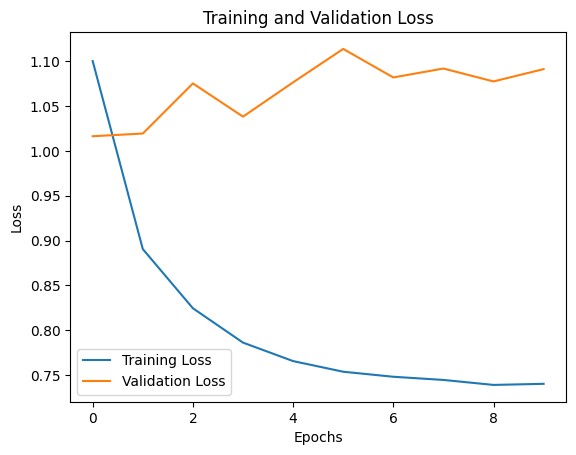

In [ ]:
from matplotlib import pyplot as plt
# Access the loss values from the history object
train_loss = bestmodelhistory.history['loss']
val_loss = bestmodelhistory.history['val_loss']
# Plot the training and validation loss
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Add legend
plt.legend()

# Display the graph
plt.show()

Simply train the model with 1 epoch gives the lowest validation loss

In [ ]:
#dim, hidden_layer, dropout = min_key[0]
#print(min_key[0])

model = tf.keras.models.load_model('WideandDeepModels/model-'+str(dim)+'-'+str(hidden_layer)+'-'+str(dropout)+'.h5')#model name has to be changed later, after obtaining the best model
y_pred = model.predict(val_features)
print("Validation set RMSE: ", rmse(y_pred, val_ratings))

(256, (512, 256), 0.5)
207/207 [==============================] - 1s 5ms/step
Validation set RMSE:  1.0114345378069607


In [ ]:
# prediction_df = pd.read_csv('data/prediction.csv')
# model = tf.keras.models.load_model('bestwdlmodel-'+str(1)+'.h5')#model name has to be changed later, after obtaining the best model
# y_pred = model.predict(pred_features)
# prediction_df["Star"] = np.round(y_pred).astype(int)
# #save the prediction
# prediction_df.to_csv("predictionwdl.csv", index=False)